In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn

import gymnasium as gym

In [69]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, self.action_n)
        )

        self.softmax = nn.Softmax(dim=-1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state):
        state = torch.FloatTensor(np.array(state))
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)
        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        elite_actions = torch.LongTensor(np.array(elite_actions))

        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [70]:
def get_trajectory(env, agent, trajectory_len, visualize=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}

    state, _ = env.reset()
    trajectory['states'].append(state)

    for _ in range(trajectory_len):

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        state, reward, done, truncate, _ = env.step(action)

        if done or truncate:
            break

        if visualize:
            env.render()
        trajectory['total_reward'] += reward
        trajectory['states'].append(state)

    return trajectory

In [71]:
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

## CartPole

![CartPole](https://gymnasium.farama.org/_images/cart_pole.gif "CartPole")

In [72]:
env = gym.make('CartPole-v1')

In [73]:
env.observation_space.shape[0], env.action_space.n  #type: ignore

(4, np.int64(2))

In [82]:
state_dim = env.observation_space.shape[0]  #type: ignore
action_n = env.action_space.n   #type: ignore

agent = CEM(state_dim, action_n)
episode_n = 200
trajectory_n = 40
trajectory_len = 500
q_param = 0.6
total_reward = []


In [83]:
for episode in tqdm(range(episode_n)):
    trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]

    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    total_reward.append(mean_total_reward)

    elite_trajectories = get_elite_trajectories(trajectories, q_param)

    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)

100%|██████████| 200/200 [07:16<00:00,  2.18s/it]


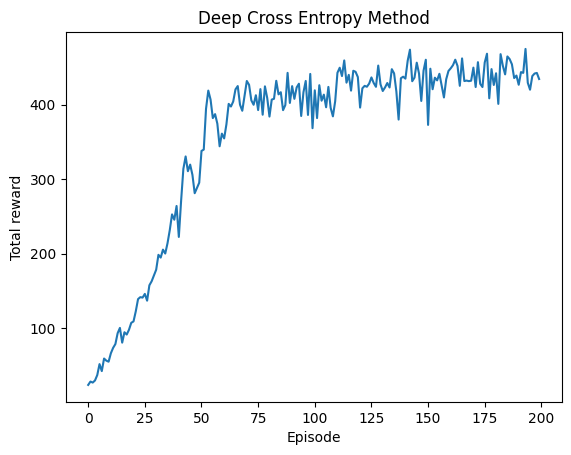

In [84]:
plt.plot(total_reward)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Deep Cross Entropy Method')
plt.show()